<a href="https://colab.research.google.com/github/jhanvi0905/skin-disease-detection/blob/master/skin-disease-detection/notebooks/Skin_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unzip /content/data_3class_skin_diseases.zip

In [46]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [65]:
from torch.utils.data import random_split
TRANSFORM_IMG = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(256),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(root="/content/data_3class_skin_diseases", transform=TRANSFORM_IMG)
dataset_size = dataset.__len__()
train_count = int(dataset_size * 0.8)
val_count = dataset_size - train_count
train_dataset, valid_dataset = random_split(dataset, [train_count, val_count])

In [66]:
train_label_indices = train_dataset.indices
print(train_label_indices)
y_train = [dataset.targets[i] for i in train_label_indices]
y_target = [dataset.targets[i] for i in valid_dataset.indices]
class_instances = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])


[14, 32, 97, 31, 85, 22, 53, 50, 92, 87, 54, 38, 99, 37, 0, 49, 27, 57, 60, 64, 16, 55, 52, 72, 1, 2, 36, 58, 65, 88, 91, 61, 67, 69, 35, 46, 6, 95, 59, 8, 68, 34, 82, 66, 20, 94, 26, 30, 25, 45, 48, 13, 41, 19, 77, 7, 75, 51, 84, 100, 101, 89, 73, 40, 80, 76, 90, 5, 98, 33, 18, 62, 39, 63, 3, 86, 24, 79, 9, 21, 15]


In [67]:
print(class_instances)
weight = 1. / class_instances
instance_weight = np.array([weight[t] for t in y_train])
instance_weight = torch.from_numpy(instance_weight)
print(instance_weight)

[32 12 37]
tensor([0.0312, 0.0312, 0.0270, 0.0312, 0.0270, 0.0312, 0.0833, 0.0833, 0.0270,
        0.0270, 0.0833, 0.0312, 0.0270, 0.0312, 0.0312, 0.0833, 0.0312, 0.0270,
        0.0270, 0.0270, 0.0312, 0.0833, 0.0833, 0.0270, 0.0312, 0.0312, 0.0312,
        0.0270, 0.0270, 0.0270, 0.0270, 0.0270, 0.0270, 0.0270, 0.0312, 0.0833,
        0.0312, 0.0270, 0.0270, 0.0312, 0.0270, 0.0312, 0.0270, 0.0270, 0.0312,
        0.0270, 0.0312, 0.0312, 0.0312, 0.0833, 0.0833, 0.0312, 0.0833, 0.0312,
        0.0270, 0.0312, 0.0270, 0.0833, 0.0270, 0.0270, 0.0270, 0.0270, 0.0270,
        0.0833, 0.0270, 0.0270, 0.0270, 0.0312, 0.0270, 0.0312, 0.0312, 0.0270,
        0.0312, 0.0270, 0.0312, 0.0270, 0.0312, 0.0270, 0.0312, 0.0312, 0.0312],
       dtype=torch.float64)


In [69]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(instance_weight.type('torch.DoubleTensor'), len(instance_weight), replacement=True)
train_dataloader = data.DataLoader(train_dataset, batch_size=5, sampler=sampler)
test_loader = data.DataLoader(valid_dataset, batch_size = 4)

In [70]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    print(image.shape)
    image = image.transpose(1, 2, 0)

    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

Instance of Loaded Samples
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


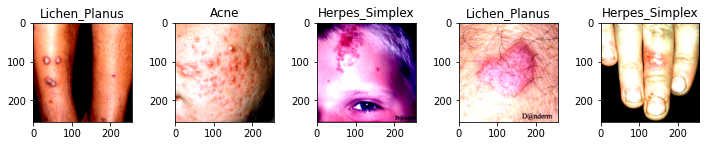

In [73]:
import matplotlib.pyplot as plt

data_iter = iter(train_dataloader)
images, labels = data_iter.next()
fig = plt.figure(figsize=(25, 4))
print("Instance of Loaded Samples")
classes = ['Acne', 'Herpes_Simplex','Lichen_Planus']
for idx in np.arange(5):
  fig.add_subplot(2,10,idx+1)
  plt.imshow(im_convert(images[idx]))
  plt.title(classes[labels[idx].item()])

In [74]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [76]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels= 3 , out_channels=16, kernel_size= 5, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels= 16 , out_channels=32, kernel_size= 3, stride=2)
        self.linear = torch.nn.Linear(32*31*31,3)


    def forward(self, x):  
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.linear(x.view(-1,32*31*31))
        return x

In [77]:
import matplotlib.pyplot as plt
model = MyModel()
cuda = torch.cuda.is_available()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [78]:
for epoch in range(10):
  train(model, 'cpu', train_dataloader, optimizer, epoch)

Train Epoch: 0 [16/81 (94%)]	Loss: 0.751337
Train Epoch: 1 [16/81 (94%)]	Loss: 1.165955
Train Epoch: 2 [16/81 (94%)]	Loss: 0.299430
Train Epoch: 3 [16/81 (94%)]	Loss: 0.009054
Train Epoch: 4 [16/81 (94%)]	Loss: 0.126887
Train Epoch: 5 [16/81 (94%)]	Loss: 0.000142
Train Epoch: 6 [16/81 (94%)]	Loss: 0.031770
Train Epoch: 7 [16/81 (94%)]	Loss: 0.001028
Train Epoch: 8 [16/81 (94%)]	Loss: 0.016764
Train Epoch: 9 [16/81 (94%)]	Loss: 0.000062


In [79]:
model.eval()
y_pred_list = []
y_targets = []
with torch.no_grad():
    model.eval()
    print(test_loader)
    for images, target in test_loader:
        y_test_pred = model(images)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.extend(y_pred_tags.cpu().numpy())
        y_targets.extend(target.numpy())
#y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [80]:
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'acne', 1: 'herpes_simplex', 2: 'lichen_planus'}

In [81]:
y_pred_list

[2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 2]

In [82]:
y_targets

[0, 2, 1, 0, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 2, 2, 2, 0, 1]

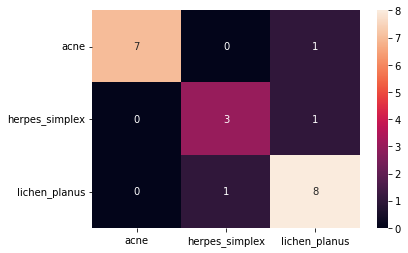

In [83]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score 

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_targets, y_pred_list)).rename(columns=idx_to_class, index=idx_to_class)

sns.heatmap(confusion_matrix_df, annot=True)

In [84]:
print(classification_report(y_targets, y_pred_list))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.75      0.75      0.75         4
           2       0.80      0.89      0.84         9

    accuracy                           0.86        21
   macro avg       0.85      0.84      0.84        21
weighted avg       0.87      0.86      0.86        21



In [85]:
print("Accuracy", accuracy_score(y_targets, y_pred_list))

Accuracy 0.8571428571428571
